<a href="https://colab.research.google.com/github/Maheer24/Goodreads-Distilbert-Multiclass-Genre-Classifier/blob/main/distilbert_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine Tuning Distilbert For Multi Class Genre Prediction**

We will fine tune a pre trained distilbert model `DistilBertForSequenceClassification` for multi class classification of genres.

# **1. Import Necessary Libraries**

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

RANDOM_STATE = 42

# **2. Pre-process Data**

In [ ]:
df = pd.read_csv("/CombinedSummaries.csv")

In [ ]:
df.head()

,Unnamed: 0,GroupedGenres,Clean_summary
0,0,Horror and Paranormal,story four seekers arrive notoriously unfriend...
1,1,Youth Literature (Children and Young Adult),last year annabel girl everything least part p...
2,2,Classics and Historical,first volume monumental trilogy liberation eur...
3,3,Classics and Historical,early hours january north vietnamese launched ...
4,4,Literary Fiction,shakespeare king lear challenges us magnitude ...


In [ ]:
df.drop('Unnamed: 0', inplace = True, axis = 1)

In [ ]:
df.head()

,GroupedGenres,Clean_summary
0,Horror and Paranormal,story four seekers arrive notoriously unfriend...
1,Youth Literature (Children and Young Adult),last year annabel girl everything least part p...
2,Classics and Historical,first volume monumental trilogy liberation eur...
3,Classics and Historical,early hours january north vietnamese launched ...
4,Literary Fiction,shakespeare king lear challenges us magnitude ...


In [ ]:
df.isna().sum()

,0
GroupedGenres,0
Clean_summary,2


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

,0
GroupedGenres,0
Clean_summary,0


In [ ]:
df.shape

(7062, 2)

# **3. Encoding Genres**

In [ ]:
df['EncodedGenres'] = df['GroupedGenres'].astype('category').cat.codes

In [ ]:
df.head()

,GroupedGenres,Clean_summary,EncodedGenres
0,Horror and Paranormal,story four seekers arrive notoriously unfriend...,4
1,Youth Literature (Children and Young Adult),last year annabel girl everything least part p...,13
2,Classics and Historical,first volume monumental trilogy liberation eur...,1
3,Classics and Historical,early hours january north vietnamese launched ...,1
4,Literary Fiction,shakespeare king lear challenges us magnitude ...,6


In [ ]:
df[['GroupedGenres','EncodedGenres']].value_counts()

,,count
GroupedGenres,EncodedGenres,
Fiction,3,1158
Fantasy,2,914
Mystery,7,748
Classics and Historical,1,716
Psychology,8,621
Youth Literature (Children and Young Adult),13,549
Inspirational and Self-Help,5,369
Science Fiction,10,366
Suspense and Thriller,12,344


# **4. Covert data to list**

In [ ]:
data_text = df['Clean_summary'].to_list()

data_labels = df['EncodedGenres'].to_list()

In [ ]:
df['EncodedGenres'].value_counts()

,count
EncodedGenres,
3,1158
2,914
7,748
1,716
8,621
13,549
5,369
10,366
12,344


# **5. Train Test Split**

We'll use a stratified train_test_split to ensure same ratio of classes is present in training, validation and test data

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(data_text, data_labels, test_size = 0.2, stratify = data_labels, random_state = RANDOM_STATE)

train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size = 0.01, stratify = train_labels, random_state = RANDOM_STATE)

# **6. Model Definition**

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 14)

In [ ]:
def encode_data(texts):
  return tokenizer(texts, truncation = True, padding = True, max_length = 512, return_tensors = 'pt')

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = encode_data(train_text)

val_encodings = encode_data(val_text)

# **7. Custom Dataset**

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    item = {'input_ids': self.encodings['input_ids'][idx], 'attention_mask': self.encodings['attention_mask'][idx]}
    item['labels'] = torch.tensor(self.labels[idx])

    return item


In [ ]:
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


# **8. Fine Tuning with TF Trainer class**

### **a. Compute Class weights**

In [ ]:
class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)
class_weights = torch.tensor(class_weights, dtype = torch.float).to(model.device)
print(class_weights)

tensor([2.4964, 0.7045, 0.5517, 0.4356, 1.7992, 1.3679, 2.4964, 0.6747, 0.8118,
        1.9971, 1.3773, 1.4849, 1.4685, 0.9182])


### **b. Compute Focal Loss**

In [ ]:
class FocalLoss(torch.nn.Module):
  def __init__(self, alpha, gamma = 2):
    super(FocalLoss, self).__init__()
    self.alpha = torch.tensor(alpha, dtype = torch.float32)
    self.gamma = gamma

  def forward(self, inputs, targets):
    self.alpha = self.alpha.to(inputs.device)

    # Compute cross entropy loss
    ce_loss = F.cross_entropy(inputs, targets, reduction = 'none')

    # Compute probabilities
    pt = torch.exp(-ce_loss)

    # alpha values for target classes
    alpha_t = self.alpha[targets]

    focal_loss = alpha_t * ((1 - pt) ** self.gamma) * ce_loss
    return focal_loss.mean()

### **c. Compute Evaluation Metrics**

In [ ]:
# Writing a function to calculate metrics

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  accuracy = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average = 'weighted')

  return {
      'accuracy': accuracy,
      'f1': f1,
  }

### **d. Write a Custom Trainer**

In [ ]:
# Writing a custom trainer to assign weights to classes

class WeightedLossTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs = False, **kwargs):
    device = model.device
    labels = inputs.pop('labels').to(device)
    outputs = model(**inputs)
    logits = outputs.logits

    focal_loss_fn = FocalLoss(alpha = class_weights.to(device), gamma = 2)
    loss = focal_loss_fn(logits, labels)

    return (loss, outputs) if return_outputs else loss

In [ ]:
# training arguments
EVAL_STEPS = 100

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
    warmup_steps = 500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps= EVAL_STEPS,
    logging_steps=100,
    save_steps = EVAL_STEPS,
    evaluation_strategy="steps",
    report_to="none",
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss'
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

trainer = WeightedLossTrainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    callbacks = [early_stopping_callback]
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:
# print(train_encodings.keys())
# print(train_encodings['input_ids'].shape)


# **9. Saving the Trained Model**

In [ ]:
#model_path = "/content/results/checkpoint-1400"

In [ ]:
# tokenizer.save_pretrained(model_path)
# model.save_pretrained(model_path)

In [ ]:
# !zip -r model_checkpoint.zip /content/results/checkpoint-1400

In [ ]:
# from google.colab import files
# files.download("model_checkpoint.zip")

# **10. Evaluating The Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_path = '/content/drive/MyDrive/model_checkpoint_62/content/results/checkpoint-1400'

tokenizer = DistilBertTokenizer.from_pretrained(checkpoint_path)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)


In [ ]:
encoded_input = tokenizer(test_text, padding = True, truncation = True, max_length = 512, return_tensors = 'pt')

In [ ]:
with torch.no_grad():
  output = model(**encoded_input)

predictions = F.softmax(output.logits, dim = -1)
predicted_labels = torch.argmax(predictions, dim = -1).numpy()


In [ ]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.71      0.83      0.77         6
           2       0.57      0.57      0.57         7
           3       0.60      0.33      0.43         9
           4       0.00      0.00      0.00         2
           5       0.50      0.33      0.40         3
           6       0.50      1.00      0.67         2
           7       0.80      0.67      0.73         6
           8       0.40      0.40      0.40         5
           9       0.40      1.00      0.57         2
          10       0.60      1.00      0.75         3
          11       0.50      0.67      0.57         3
          12       0.00      0.00      0.00         3
          13       0.67      0.50      0.57         4

    accuracy                           0.56        57
   macro avg       0.52      0.59      0.53        57
weighted avg       0.56      0.56      0.54        57



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


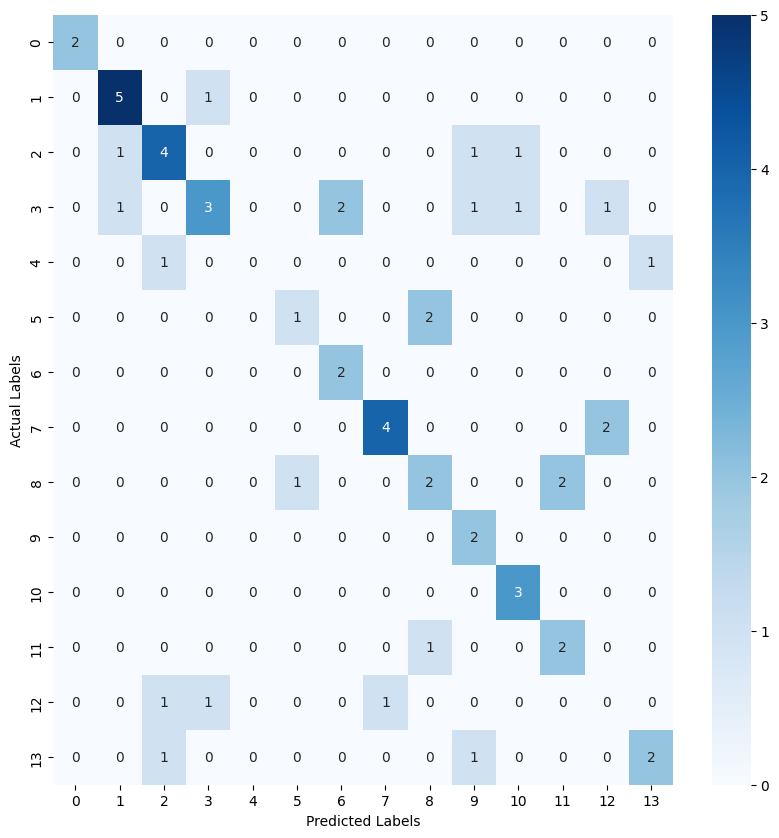

In [ ]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()